## Data Processing Sign Images

In [ ]:
import keras
# Remove some unwanted warnings
import logging
logging.getLogger('tensorflow').disabled = True
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import shutil
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
#change main_dir if running locally
main_dir = "C:/Users/aless/My Drive (i.lupascu@tilburguniversity.edu)/Language Models Project/Code"

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

sign_data_dir = main_dir + "/Datasets/SignImages/Gesture Image Data"

# Create an ImageDataGenerator without validation split
datagen = ImageDataGenerator(rescale=1./255)

# Generate training data only
train_generator = datagen.flow_from_directory(
    sign_data_dir,
    target_size=(50, 50),  # Adjust based on your needs
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

Found 36000 images belonging to 24 classes.


In [ ]:
n_batches = 225

# Preallocate NumPy arrays for all the data
X_train_lang = np.zeros((n_batches*32, 50, 50, 3), dtype=np.float32)
Y_train_lang = np.zeros((n_batches*32, train_generator.num_classes), dtype=np.float32)

# Loop through the generator and populate the arrays
current_index = 0
batch_count = 0  # Add a counter for batches

for images, labels in train_generator:
    batch_size = images.shape[0]
    X_train_lang[current_index:current_index + batch_size] = images
    Y_train_lang[current_index:current_index + batch_size] = labels
    current_index += batch_size
    batch_count += 1  # Increment batch counter

    if batch_count >= n_batches:  # Check if n_batches is reached
        break  # Stop when all samples are processed

print("X_train_lang shape:", X_train_lang.shape)
print("Y_train_lang shape:", Y_train_lang.shape)

X_train_lang shape: (7200, 50, 50, 3)
Y_train_lang shape: (7200, 24)


In [ ]:
print(Y_train_lang[0])

[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


## Data Processing Natural Images

In [ ]:
from PIL import Image
import os
import numpy as np

# Initialize lists to hold images and labels
X_train_vis = []
Y_train_vis = []

n_images = 7200
count = 0
label_count = [0 for i in range(36)]

nat_images_dir = main_dir + "/Datasets/NaturalImages2/dataset_26"
# Define the directories for images and labels
image_dir = nat_images_dir + '/train/images'
label_dir = nat_images_dir + '/train/labels'

# Loop through each file in the image directory
for filename in os.listdir(image_dir):
    if filename.endswith('.jpg'):  # Check for .jpg files
        # Load the corresponding label
        label_filename = filename.replace('.jpg', '.txt')  # Change extension to .txt
        label_path = os.path.join(label_dir, label_filename)

        # Check if the label file is not empty
        if os.path.exists(label_path) and os.path.getsize(label_path) > 0:
            # Read the label from the text file
            with open(label_path, 'r') as label_file:
                label = label_file.read().strip()  # Read and strip any extra whitespace
                first_word = label.split()[0]  # Get the first word from the label
            
            if label_count[int(first_word)] >= 300: continue
            label_count[int(first_word)] += 1
            
            # Load the image only if the label is not empty
            image_path = os.path.join(image_dir, filename)
            with Image.open(image_path) as image:  # Use 'with' to ensure the image file is closed
                image = image.resize((100, 100))  # Resize to 50x50 pixels
                # Convert image to a NumPy array and normalize the pixels
                image_array = np.array(image, dtype=np.float32) / 255.0  # Normalize pixels
                X_train_vis.append(image_array)  # Append the normalized image to the list
                Y_train_vis.append(first_word)  # Append the first word to the list

            # Add 1 to count of images added
            count += 1
            if count >= n_images: break

# Convert lists to NumPy arrays for further processing
X_train_vis = np.array(X_train_vis)
Y_train_vis = np.array(Y_train_vis)

print("X_train_vis shape:", X_train_vis.shape)
print("Y_train_vis shape:", Y_train_vis.shape)

X_train_vis shape: (6996, 100, 100, 3)
Y_train_vis shape: (6996,)


In [ ]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output=False)  # Create an encoder instance
Y_train_vis = encoder.fit_transform(np.array(Y_train_vis).reshape(-1, 1))  # Fit and transform

In [ ]:
print(X_train_vis.shape)
print(Y_train_vis.shape)
print(Y_train_vis[0])

(6996, 100, 100, 3)
(6996, 24)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


In [ ]:
import numpy as np

# Decode one-hot encoded labels to class indices
class_indices_vis = np.argmax(Y_train_vis, axis=1)
class_indices_lang = np.argmax(Y_train_lang, axis=1)

# Group data by class
from collections import defaultdict

vis_dict = defaultdict(list)
lang_dict = defaultdict(list)

for i, label in enumerate(class_indices_vis):
    vis_dict[label].append(X_train_vis[i])

for i, label in enumerate(class_indices_lang):
    lang_dict[label].append(X_train_lang[i])

# Align and merge the datasets
X_train_vis_lang = []
Y_train_vis_lang = []

for label in range(24):  # Assuming 24 classes
    vis_samples = vis_dict[label]
    lang_samples = lang_dict[label]

    # Pair images from both datasets with the same label
    for vis_img, lang_img in zip(vis_samples, lang_samples):
        X_train_vis_lang.append((vis_img, lang_img))
        Y_train_vis_lang.append(np.eye(24)[label])  # Re-encode the label as one-hot

# Convert to numpy arrays
X_train_vis_lang = np.array(X_train_vis_lang, dtype=object)  # Use dtype=object for tuples
Y_train_vis_lang = np.array(Y_train_vis_lang)

print(f"Shape of X_train_vis_lang: {X_train_vis_lang.shape}")  # Expecting (n_samples, 2)
print(f"Shape of Y_train_vis_lang: {Y_train_vis_lang.shape}")  # Expecting (n_samples, 24)


Shape of X_train_vis_lang: (6859, 2)
Shape of Y_train_vis_lang: (6859, 24)


In [ ]:
import matplotlib.pyplot as plt

count = 0

for idx, x in enumerate(Y_train_vis_lang):
    print(Y_train_vis_lang)
    if x[2] == 1:
        plt.imshow(X_train_vis_lang[idx][0])
        plt.axis('off')  # Hide axes
        plt.show()
        plt.imshow(X_train_vis_lang[idx][1])
        plt.axis('off')  # Hide axes
        plt.show()
        count += 1
        if count > 10: break


In [ ]:
from sklearn.model_selection import train_test_split

# Assuming X_train_vis_lang and Y_train_vis_lang are your datasets
# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(
    X_train_vis_lang,      # Features
    Y_train_vis_lang,      # Labels
    test_size=0.2,         # 20% of the data will be used for testing
    random_state=42        # For reproducibility
)

# Now you can use X_train, X_test, Y_train_split, and Y_test for your model
print("Training set size:", X_train.shape)
print("Testing set size:", X_test.shape)
print("Training set size:", Y_train.shape)
print("Testing set size:", Y_test.shape)

Training set size: (5487, 2)
Testing set size: (1372, 2)
Training set size: (5487, 24)
Testing set size: (1372, 24)


## Language Model

In [ ]:
from keras.applications.vgg16 import VGG16
from tensorflow.keras import layers
from keras.models import Model
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, concatenate

In [ ]:
# load model without output layer and specify a new input shape for images
def build_lang_model():
    lang_model = VGG16(include_top=False, input_shape=(50, 50, 3))
    
    # mark loaded layers as not trainable
    for layer in lang_model.layers:
    	layer.trainable = False
    
    # changing name of the layers to distinguish between the two models    
    for layer in lang_model.layers:
        layer.name = layer.name + str('_L')
        
    # add new classifier layers
    #add flatten layer
    flat1 = layers.Flatten()(lang_model.layers[-1].output)
    #add Dense layer
    class1 = layers.Dense(64, activation='relu')(flat1)
    class2 = layers.Dense(64, activation='relu')(class1)
    
    #output to connect to other dense layer
    lang_output = layers.Dense(32, activation='relu')(class2)
    
    lang_model = Model(inputs=lang_model.input, outputs=lang_output)
    return lang_model

## Visual Model

In [ ]:
def build_vis_model():
    # load model without output layer and specify a new input shape for images
    vis_model = VGG16(include_top=False, input_shape=(100, 100, 3))
    
    # mark loaded layers as not trainable
    for layer in vis_model.layers:
    	layer.trainable = False
        
    # changing name of the layers to distinguish between the two models
    for layer in vis_model.layers:
        layer.name = layer.name + str('_V')
    # add new classifier layers
    #add flatten layer
    flat1 = layers.Flatten()(vis_model.layers[-1].output)
    #add Dense layer
    class1 = layers.Dense(64, activation='relu')(flat1)
    class2 = layers.Dense(64, activation='relu')(class1)
    
    #output to connect to other dense layer
    vis_output = layers.Dense(32, activation='relu')(class2)
    vis_model = Model(inputs=vis_model.input, outputs=vis_output)

    return vis_model

## Joining the Models

In [ ]:
def build_final_model():
    # build language model
    lang_model = build_lang_model()
    vis_model = build_vis_model()
    # Concatenate the outputs of the two models
    merged = concatenate([lang_model.output, vis_model.output])
    
    # Add final layers
    class3 = Dense(32, activation='relu')(merged)
    final_output = Dense(24, activation='softmax')(class3)
    
    model = Model(inputs=[lang_model.inputs, vis_model.inputs], outputs=final_output)
    
    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return lang_model, vis_model, model

In [ ]:
lang_model1, vis_model1, non_depr_model = build_final_model()

In [ ]:
non_depr_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_L       │ (None, 50, 50, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1_V     │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_L      │ (None, 50, 50,    │      1,792 │ input_layer_L[0]… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_V      │ (None, 100, 100,  │      1,792 │ input_layer_1_V[… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_L      │ (None, 50, 50,    │     36,928 │ block1_conv1_L[0… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_V      │ (None, 100, 100,  │     36,928 │ block1_conv1_V[0… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool_L       │ (None, 25, 25,    │          0 │ block1_conv2_L[0… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool_V       │ (None, 50, 50,    │          0 │ block1_conv2_V[0… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1_L      │ (None, 25, 25,    │     73,856 │ block1_pool_L[0]… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1_V      │ (None, 50, 50,    │     73,856 │ block1_pool_V[0]… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2_L      │ (None, 25, 25,    │    147,584 │ block2_conv1_L[0… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2_V      │ (None, 50, 50,    │    147,584 │ block2_conv1_V[0… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool_L       │ (None, 12, 12,    │          0 │ block2_conv2_L[0… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool_V       │ (None, 25, 25,    │          0 │ block2_conv2_V[0… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1_L      │ (None, 12, 12,    │    295,168 │ block2_pool_L[0]… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1_V      │ (None, 25, 25,    │    295,168 │ block2_pool_V[0]… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2_L      │ (None, 12, 12,    │    590,080 │ block3_conv1_L[0

 Total params: 29,772,536 (113.57 MB)

 Trainable params: 343,160 (1.31 MB)

 Non-trainable params: 29,429,376 (112.26 MB)

## Training the Non-Deprived Model

The learning rate slowly decreases through the epochs, going from 0.001 to 0.00001. The total number of epochs is increased to 50 and the batch size is reduced to 500.

In [ ]:
'''
import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

# Define parameters
initial_lr = 0.001
decay_rate = 0.1
epochs = 50
sample_size = 500

# Learning rate schedule
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_lr,
    decay_steps=1,
    decay_rate=decay_rate
)

# Optimizer and model compilation
optimizer = Adam(learning_rate=lr_schedule)
non_depr_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Training loop
for epoch in range(epochs):
    indices = np.random.choice(len(X_train), sample_size, replace=False)
    X_sample = X_train[indices]
    Y_sample = Y_train[indices]

    vis_data = np.stack(X_sample[:, 0], axis=0)
    lang_data = np.stack(X_sample[:, 1], axis=0)

    print(f"Epoch {epoch+1}/{epochs}")

    # Train the model
    non_depr_model.fit([lang_data, vis_data], Y_sample, epochs=1, batch_size=32)
'''

'\nimport numpy as np\nimport tensorflow as tf\nfrom tensorflow.keras.optimizers import Adam\n\n# Define parameters\ninitial_lr = 0.001\ndecay_rate = 0.1\nepochs = 50\nsample_size = 500\n\n# Learning rate schedule\nlr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(\n    initial_learning_rate=initial_lr,\n    decay_steps=1,\n    decay_rate=decay_rate\n)\n\n# Optimizer and model compilation\noptimizer = Adam(learning_rate=lr_schedule)\nnon_depr_model.compile(optimizer=optimizer, loss=\'categorical_crossentropy\', metrics=[\'accuracy\'])\n\n# Training loop\nfor epoch in range(epochs):\n    indices = np.random.choice(len(X_train), sample_size, replace=False)\n    X_sample = X_train[indices]\n    Y_sample = Y_train[indices]\n\n    vis_data = np.stack(X_sample[:, 0], axis=0)\n    lang_data = np.stack(X_sample[:, 1], axis=0)\n\n    print(f"Epoch {epoch+1}/{epochs}")\n\n    # Train the model\n    non_depr_model.fit([lang_data, vis_data], Y_sample, epochs=1, batch_size=32)\n'

In [ ]:
# Define parameters
initial_lr = 0.015
decay_rate = 0.95

# Learning rate schedule
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_lr,
    decay_steps=50,
    decay_rate=decay_rate
)

In [ ]:
new_lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,  # Reset initial learning rate
    decay_steps=50,
    decay_rate=0.95
)
optimizer.learning_rate = new_lr_schedule

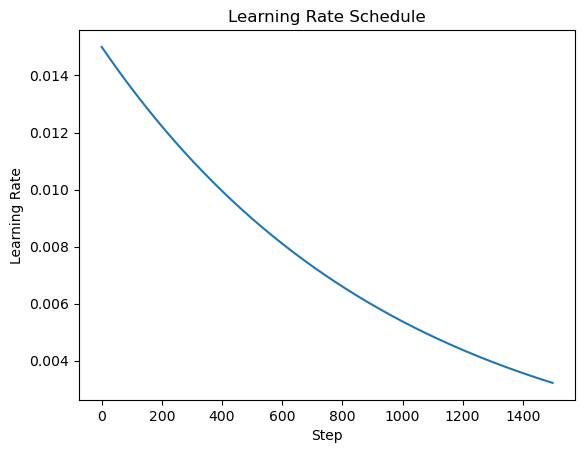

In [ ]:
import matplotlib.pyplot as plt

steps = range(1500) # number of steps in a 10 epochs training 
learning_rates = [lr_schedule(step) for step in steps]

plt.plot(steps, learning_rates)
plt.xlabel("Step")
plt.ylabel("Learning Rate")
plt.title("Learning Rate Schedule")
plt.show()


In [ ]:
# Reset weights to initial state
for layer in non_depr_model.layers:
    if hasattr(layer, 'kernel_initializer'):
        layer.kernel.assign(layer.kernel_initializer(layer.kernel.shape))
    if hasattr(layer, 'bias_initializer'):
        layer.bias.assign(layer.bias_initializer(layer.bias.shape))

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

# Define parameters
epochs = 10
sample_size = 5000

indices = np.random.choice(len(X_train), sample_size, replace=False)

# Select the samples from X_train and Y_train
X_sample = X_train[indices]
Y_sample = Y_train[indices]

# Optimizer and model compilation
optimizer = Adam(learning_rate=lr_schedule)

# non_depr_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
non_depr_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


# Split the data into two separate inputs
vis_data = X_sample[:, 0]  # First column for language input
lang_data = X_sample[:, 1]   # Second column for visual input

# Changing the shape of the tensor to fit the input of the model
lang_data = np.stack(lang_data, axis=0)
vis_data = np.stack(vis_data, axis=0)
labels = Y_sample

# Preparing the test datasets
vis_test = X_test[:, 0]
lang_test = X_test[:, 1]
vis_test = np.stack(vis_test, axis=0)
lang_test = np.stack(lang_test, axis=0)

labels_test = Y_test

# Training
history = non_depr_model.fit([lang_data, vis_data], labels, epochs=10, batch_size=32, validation_data=([lang_test, vis_test], labels_test))
test_loss, test_acc = non_depr_model.evaluate([lang_test, vis_test], labels_test)

Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 67s 406ms/step - accuracy: 0.0429 - loss: 3.1771 - val_accuracy: 0.0474 - val_loss: 3.1683
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 67s 427ms/step - accuracy: 0.0587 - loss: 3.1167 - val_accuracy: 0.1348 - val_loss: 2.4923
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 70s 447ms/step - accuracy: 0.1684 - loss: 2.3952 - val_accuracy: 0.3185 - val_loss: 2.1289
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 75s 477ms/step - accuracy: 0.3067 - loss: 2.0850 - val_accuracy: 0.3433 - val_loss: 1.8792
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 75s 476ms/step - accuracy: 0.3519 - loss: 1.8540 - val_accuracy: 0.3819 - val_loss: 1.7456
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 74s 475ms/step - accuracy: 0.3732 - loss: 1.7363 - val_accuracy: 0.3827 - val_loss: 1.7176
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 75s 480ms/step - accuracy: 0.4141 - loss: 1.6242 - val_accuracy: 0.4555 - val_loss: 1.5317
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 75s 479ms/step - accuracy: 0.4400 - loss: 1

In [ ]:
vis3, lang3

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

# Define parameters
epochs = 10
sample_size = 5000

indices = np.random.choice(len(X_train), sample_size, replace=False)

# Select the samples from X_train and Y_train
X_sample = X_train[indices]
Y_sample = Y_train[indices]

# Optimizer and model compilation
optimizer = Adam(learning_rate=lr_schedule)

# non_depr_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
non_depr_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


# Split the data into two separate inputs
vis_data = X_sample[:, 0]  # First column for language input
lang_data = X_sample[:, 1]   # Second column for visual input

# Changing the shape of the tensor to fit the input of the model
lang_data = np.stack(lang_data, axis=0)
vis_data = np.stack(vis_data, axis=0)
labels = Y_sample

# Preparing the test datasets
vis_test = X_test[:, 0]
lang_test = X_test[:, 1]
vis_test = np.stack(vis_test, axis=0)
lang_test = np.stack(lang_test, axis=0)

labels_test = Y_test

# Training
history = non_depr_model.fit([lang_data, vis_data], labels, epochs=10, batch_size=32, validation_data=([lang_test, vis_test], labels_test))
test_loss, test_acc = non_depr_model.evaluate([lang_test, vis_test], labels_test)

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

# Define parameters
epochs = 10
sample_size = 5000

indices = np.random.choice(len(X_train), sample_size, replace=False)

# Select the samples from X_train and Y_train
X_sample = X_train[indices]
Y_sample = Y_train[indices]

# Optimizer and model compilation
optimizer = Adam(learning_rate=lr_schedule)

# non_depr_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
non_depr_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


# Split the data into two separate inputs
vis_data = X_sample[:, 0]  # First column for language input
lang_data = X_sample[:, 1]   # Second column for visual input

# Changing the shape of the tensor to fit the input of the model
lang_data = np.stack(lang_data, axis=0)
vis_data = np.stack(vis_data, axis=0)
labels = Y_sample

# Preparing the test datasets
vis_test = X_test[:, 0]
lang_test = X_test[:, 1]
vis_test = np.stack(vis_test, axis=0)
lang_test = np.stack(lang_test, axis=0)

labels_test = Y_test

# Training
history = non_depr_model.fit([lang_data, vis_data], labels, epochs=10, batch_size=32, validation_data=([lang_test, vis_test], labels_test))
test_loss, test_acc = non_depr_model.evaluate([lang_test, vis_test], labels_test)

Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 67s 406ms/step - accuracy: 0.0429 - loss: 3.1771 - val_accuracy: 0.0474 - val_loss: 3.1683
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 67s 427ms/step - accuracy: 0.0587 - loss: 3.1167 - val_accuracy: 0.1348 - val_loss: 2.4923
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 70s 447ms/step - accuracy: 0.1684 - loss: 2.3952 - val_accuracy: 0.3185 - val_loss: 2.1289
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 75s 477ms/step - accuracy: 0.3067 - loss: 2.0850 - val_accuracy: 0.3433 - val_loss: 1.8792
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 75s 476ms/step - accuracy: 0.3519 - loss: 1.8540 - val_accuracy: 0.3819 - val_loss: 1.7456
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 74s 475ms/step - accuracy: 0.3732 - loss: 1.7363 - val_accuracy: 0.3827 - val_loss: 1.7176
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 75s 480ms/step - accuracy: 0.4141 - loss: 1.6242 - val_accuracy: 0.4555 - val_loss: 1.5317
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 75s 479ms/step - accuracy: 0.4400 - loss: 1

In [ ]:
non_depr_model.summary()

In [ ]:
lang_model2, vis_model2, depr_model = build_final_model()

In [ ]:
'''
# Split the data into two separate inputs
vis_data = X_train[:, 0]  # First column for language input
lang_data = X_train[:, 1]   # Second column for visual input

# Changing the shape of the tensor to fit the input of the model
lang_data = np.stack(lang_data, axis=0)
vis_data = np.stack(vis_data, axis=0)

labels = Y_train
'''

'\n# Split the data into two separate inputs\nvis_data = X_train[:, 0]  # First column for language input\nlang_data = X_train[:, 1]   # Second column for visual input\n\n# Changing the shape of the tensor to fit the input of the model\nlang_data = np.stack(lang_data, axis=0)\nvis_data = np.stack(vis_data, axis=0)\n\nlabels = Y_train\n'

In [ ]:
'''
# Train the model with the learning rate scheduler
model.fit(X_train, Y_train, epochs=epochs, batch_size=32, callbacks=[lr_scheduler])
'''

'\n# Train the model with the learning rate scheduler\nmodel.fit(X_train, Y_train, epochs=epochs, batch_size=32, callbacks=[lr_scheduler])\n'